<a href="https://colab.research.google.com/github/iskra3138/ImageSr/blob/master/Feature_Map_Analysis_v2_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

v2
- adaptive frac 추가 : grad_cam값이 0.3보다 큰 비율 적용
- frac 1.0 추가 : binary화 하지 않고 mask값을 그냥 input에 곱해버림

v2.1
- out*grad == 0 일 때만 고려

v2.2
- NMS 적용

v2.3
- 코드 정리

In [1]:
!nvidia-smi

Sun Feb 14 11:54:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Preliminary

In [2]:
import tensorflow as tf
from tensorflow import keras
from scipy.ndimage.interpolation import zoom
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model, save_model
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import ipywidgets
from IPython.utils import io
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
import numpy as np
import pandas as pd
import cv2

import seaborn as sns
from google.colab import widgets

from time import time

In [3]:
print(f'Tf version : {tf.__version__}')
print(f'Keras version : {keras.__version__}')

Tf version : 2.4.1
Keras version : 2.4.0


In [4]:
model = tf.keras.applications.ResNet50V2(
    include_top=True, weights='imagenet', input_tensor=None, input_shape=None,
    pooling=None, classes=1000, classifier_activation='softmax'
)

102875136/102869336 [==============================] - 1s 0us/step


In [5]:
!wget -O cat1.jpg https://static.scientificamerican.com/sciam/cache/file/92E141F8-36E4-4331-BB2EE42AC8674DD3_source.jpg
Image.open('cat1.jpg').resize((224,224)).save('cat1.jpg')

--2021-02-14 11:54:58--  https://static.scientificamerican.com/sciam/cache/file/92E141F8-36E4-4331-BB2EE42AC8674DD3_source.jpg
Resolving static.scientificamerican.com (static.scientificamerican.com)... 151.101.2.49, 151.101.66.49, 151.101.130.49, ...
Connecting to static.scientificamerican.com (static.scientificamerican.com)|151.101.2.49|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 292933 (286K) [image/jpeg]
Saving to: ‘cat1.jpg’

cat1.jpg            100%[===================>] 286.07K  --.-KB/s    in 0.02s   

2021-02-14 11:54:58 (11.3 MB/s) - ‘cat1.jpg’ saved [292933/292933]



In [6]:
!wget -O cat2.jpg https://www.ctvnews.ca/polopoly_fs/1.5098407.1599687805!/httpImage/image.jpg_gen/derivatives/landscape_1020/image.jpg
Image.open('cat2.jpg').resize((224,224)).save('cat2.jpg')

--2021-02-14 11:54:58--  https://www.ctvnews.ca/polopoly_fs/1.5098407.1599687805!/httpImage/image.jpg_gen/derivatives/landscape_1020/image.jpg
Resolving www.ctvnews.ca (www.ctvnews.ca)... 184.24.190.68
Connecting to www.ctvnews.ca (www.ctvnews.ca)|184.24.190.68|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘cat2.jpg’

cat2.jpg                [ <=>                ] 124.23K  --.-KB/s    in 0.01s   

2021-02-14 11:54:58 (8.15 MB/s) - ‘cat2.jpg’ saved [127210]



In [7]:
!wget -O cat3.jpg https://img.webmd.com/dtmcms/live/webmd/consumer_assets/site_images/article_thumbnails/slideshows/people_foods_cats_can_eat_slideshow/1800x1200_people_foods_cats_can_eat_slideshow.jpg
Image.open('cat3.jpg').resize((224,224)).save('cat3.jpg')

--2021-02-14 11:54:58--  https://img.webmd.com/dtmcms/live/webmd/consumer_assets/site_images/article_thumbnails/slideshows/people_foods_cats_can_eat_slideshow/1800x1200_people_foods_cats_can_eat_slideshow.jpg
Resolving img.webmd.com (img.webmd.com)... 104.18.5.176, 104.18.4.176
Connecting to img.webmd.com (img.webmd.com)|104.18.5.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 388986 (380K) [image/jpeg]
Saving to: ‘cat3.jpg’

cat3.jpg            100%[===================>] 379.87K  --.-KB/s    in 0.02s   

2021-02-14 11:54:58 (15.0 MB/s) - ‘cat3.jpg’ saved [388986/388986]



In [8]:
!wget -O cat4.jpg https://www.rd.com/wp-content/uploads/2019/05/american-curl-kitten.jpg
Image.open('cat4.jpg').resize((224,224)).save('cat4.jpg')

--2021-02-14 11:54:58--  https://www.rd.com/wp-content/uploads/2019/05/american-curl-kitten.jpg
Resolving www.rd.com (www.rd.com)... 104.18.24.214, 104.18.25.214, 2606:4700::6812:19d6, ...
Connecting to www.rd.com (www.rd.com)|104.18.24.214|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3143084 (3.0M) [image/jpeg]
Saving to: ‘cat4.jpg’

cat4.jpg            100%[===================>]   3.00M  --.-KB/s    in 0.05s   

2021-02-14 11:54:58 (64.3 MB/s) - ‘cat4.jpg’ saved [3143084/3143084]



In [9]:
!wget -O dog1.jpg https://image.cnbcfm.com/api/v1/image/105992231-1561667465295gettyimages-521697453.jpeg
Image.open('dog1.jpg').resize((224,224)).save('dog1.jpg')

--2021-02-14 11:54:59--  https://image.cnbcfm.com/api/v1/image/105992231-1561667465295gettyimages-521697453.jpeg
Resolving image.cnbcfm.com (image.cnbcfm.com)... 2.20.34.117
Connecting to image.cnbcfm.com (image.cnbcfm.com)|2.20.34.117|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 218046 (213K) [image/jpeg]
Saving to: ‘dog1.jpg’

dog1.jpg            100%[===================>] 212.94K  --.-KB/s    in 0.03s   

2021-02-14 11:54:59 (7.80 MB/s) - ‘dog1.jpg’ saved [218046/218046]



In [10]:
!wget -O dog2.jpg https://www.sciencemag.org/sites/default/files/styles/article_main_image_-_1280w__no_aspect_/public/dogs_1280p_0.jpg
Image.open('dog2.jpg').resize((224,224)).save('dog2.jpg')

--2021-02-14 11:55:00--  https://www.sciencemag.org/sites/default/files/styles/article_main_image_-_1280w__no_aspect_/public/dogs_1280p_0.jpg
Resolving www.sciencemag.org (www.sciencemag.org)... 52.8.235.68, 52.9.23.109
Connecting to www.sciencemag.org (www.sciencemag.org)|52.8.235.68|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 145305 (142K) [image/jpeg]
Saving to: ‘dog2.jpg’

dog2.jpg            100%[===================>] 141.90K  --.-KB/s    in 0.06s   

2021-02-14 11:55:00 (2.13 MB/s) - ‘dog2.jpg’ saved [145305/145305]



In [11]:
!wget -O car.jpg https://www.businessinsider.in/thumb/msid-74437579,width-600,resizemode-4,imgsize-161974/business/auto/news/bs6-deadline-get-discounts-of-up-to-250000-on-bs4-cars-in-india/bs4-car-discounts.jpg
Image.open('car.jpg').resize((224,224)).save('car.jpg')

--2021-02-14 11:55:00--  https://www.businessinsider.in/thumb/msid-74437579,width-600,resizemode-4,imgsize-161974/business/auto/news/bs6-deadline-get-discounts-of-up-to-250000-on-bs4-cars-in-india/bs4-car-discounts.jpg
Resolving www.businessinsider.in (www.businessinsider.in)... 104.92.250.49, 2600:1409:12:49d::3621, 2600:1409:12:494::3621
Connecting to www.businessinsider.in (www.businessinsider.in)|104.92.250.49|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24221 (24K) [image/jpeg]
Saving to: ‘car.jpg’

car.jpg             100%[===================>]  23.65K  --.-KB/s    in 0.007s  

2021-02-14 11:55:00 (3.46 MB/s) - ‘car.jpg’ saved [24221/24221]



In [12]:
# Select layer to use
layer_widget1 = ipywidgets.Text(value="conv2_block1_preact_relu",
                                   description='layer 1 선택:',
                                   style={'description_width':'initial'})
layer_widget2 = ipywidgets.Text(value="conv3_block1_preact_relu",
                                   description='layer 2 선택:',
                                   style={'description_width':'initial'})
layer_widget3 = ipywidgets.Text(value="conv4_block1_preact_relu",
                                   description='layer 3 선택:',
                                   style={'description_width':'initial'})
layer_widget4 = ipywidgets.Text(value="conv5_block1_preact_relu",
                                   description='layer 4 선택:',
                                   style={'description_width':'initial'})
layer_widget5 = ipywidgets.Text(value="post_relu",
                                   description='layer 5 선택:',
                                   style={'description_width':'initial'})

mask_layers = [layer_widget1.value, layer_widget2.value, layer_widget3.value, layer_widget4.value, layer_widget5.value]

### Util

In [13]:
def make_binary_masked_image(masks, img, frac = 0.15) :
  w,h,c = masks.shape

  binary_masks = np.transpose(masks, (2, 0, 1))
  binary_masks_flat = binary_masks.reshape(c,-1)
  _, top_n_idx = tf.math.top_k(
      binary_masks_flat, k=int(w*h*frac), sorted=False, name=None
  )
  top_n_idx = top_n_idx.numpy()
  for i in range(c):
    idx = (top_n_idx[i]//w, top_n_idx[i]%w)
    binary_masks[i] = 0
    binary_masks[i][idx] = 1
  binary_masks = np.transpose(binary_masks, (1, 2, 0))
  # creates perturbed images to probe model.
  X = np.einsum('hwc,hwn->nhwc', img, binary_masks)
  return X

In [83]:
def show_scatter_plot(mask_layers, mask_names, l_inputs, l_results):
  # plot scatter plots
  #iname = ['outputs', 'outgrads', 'grads']
  iname = mask_names
  xname = ['avg', 'max', 'min']
  n_cols = len(mask_layers)
  grid = widgets.Grid(3, n_cols)

  for l in range(len(mask_layers)):
    for i, input in enumerate(l_inputs[l]) :
      avg = np.mean(input, axis=(0,1))
      min = np.min(input, axis=(0,1))
      max = np.max(input, axis=(0,1))
      for j, x in enumerate([avg,max,min]):
        with grid.output_to(j, l):
          plt.figure(figsize = (3,2))
          sns.regplot(x=x, y=l_results[l][i], fit_reg=False) # no regression line
          plt.title('{}'.format(mask_layers[l].split('_')[0]), fontsize=14)
          plt.xlabel('{} of {}'.format(xname[j], iname[i]), fontsize=14)
          plt.ylabel('preds', fontsize=14)
          plt.show()

In [117]:
def show_saliency_maps(img, mask_layers, mask_names, l_inputs, l_results, frac=0.15):
  iname = mask_names
  xname = ['avg', 'max', 'min']
  n_cols = len(mask_layers)
  grid = widgets.Grid(1+len(iname)*2, n_cols)

  for l in range(len(mask_layers)) :
    with grid.output_to(0, l):
      print (mask_layers[l])
    for i, input in enumerate(l_inputs[l]) :
      avg = np.mean(input, axis=(0,1))

      with grid.output_to(2*i+1, l):
        idx = np.argmax(l_results[l][i])
        print ("index: {}".format(idx))
        print ("avg:{:.2f}, pred{:.2f}".format(avg[idx], l_results[l][i][idx]))
        print ("result of {}".format(iname[i]))

        masks = input[:,:,idx]
        masks = tf.image.resize(masks[:,:,np.newaxis], (224,224), method='bilinear').numpy()
        masks -= np.min(masks, axis=(0,1))
        masks /= (np.max(masks, axis=(0,1))+10e-30)

        plt.figure(figsize = (3,3))
        plt.imshow(img)
        plt.imshow(masks[:,:,0], cmap='jet', alpha=0.5)
        plt.axis('off')
      with grid.output_to(2*(i+1), l):
        if frac == 1.0 :
          masked_img = np.einsum('hwc,hwn->nhwc', img, masks)[0]
        else :
          masked_img = make_binary_masked_image(masks, img, frac = frac)[0]
        plt.figure(figsize = (3,3))
        plt.imshow(masked_img)
        plt.axis('off')

In [133]:
import pandas as pd
def maks_result_table(mask_layers, mask_names, pred, l_inputs, l_results):
  first_index = []
  for layer in mask_layers :
    layer_name = layer.split('_')[0]
    first_index.append(layer_name)
  second_index = mask_names

  index_list = [[f for f in first_index for _ in range(len(mask_names))],
                [s for _ in range(5) for s in second_index]]

  feature_list = ['#_map', "masked_pred", "org_pred", "avg", "min", "max"]
  result_df = pd.DataFrame(np.zeros((len(index_list[0]),len(feature_list))), 
                          index=index_list, 
                          columns=feature_list)
  for l in range(len(mask_layers)) :
    for i, input in enumerate(l_inputs[l]) :
      idx = np.argmax(l_results[l][i])
      result_df.loc[first_index[l] , second_index[i]]['#_map'] = idx
      result_df.loc[first_index[l] , second_index[i]]['masked_pred'] = l_results[l][i][idx]
      result_df.loc[first_index[l] , second_index[i]]['org_pred'] = pred
      result_df.loc[first_index[l] , second_index[i]]['avg'] = np.mean(input, axis=(0,1))[idx]
      result_df.loc[first_index[l] , second_index[i]]['min'] = np.min(input, axis=(0,1))[idx]
      result_df.loc[first_index[l] , second_index[i]]['max'] = np.max(input, axis=(0,1))[idx]
      
  return result_df

In [134]:
# UTIL
# Felzenszwalb et al
from scipy import ndimage
from skimage.measure import label, regionprops
import matplotlib.patches as patches
import numpy as np

def non_max_suppression_fast(boxes, scores, mask_locs, iou_threshold):
  '''
  boxes : coordinates of each box
  scores : score of each box
  iou_threshold : iou threshold(box with iou larger than threshold will be removed)
	'''
  if len(boxes) == 0:
    return ([])
  
  # Init the picked box info
  pick = []
  mask_locs = np.array(mask_locs)

	# Box coordinate consist of left top and right bottom
  x1 = boxes[:,0]
  y1 = boxes[:,1]
  x2 = boxes[:,2]
  y2 = boxes[:,3]

  # Compute area of each boxes
  area = (x2 - x1 + 1) * (y2 - y1 + 1)
  # Greedily select the order of box to compare iou
  idxs = np.argsort(scores)
	
  while (len(idxs) > 0):
    last = len(idxs) - 1
    i = idxs[last]
    pick.append(i)
    
    # With vector implementation, we can calculate fast
    xx1 = np.maximum(x1[i], x1[idxs[:last]])
    yy1 = np.maximum(y1[i], y1[idxs[:last]])
    xx2 = np.minimum(x2[i], x2[idxs[:last]])
    yy2 = np.minimum(y2[i], y2[idxs[:last]])

    w = np.maximum(0, xx2 - xx1 + 1)
    h = np.maximum(0, yy2 - yy1 + 1)
    intersection = w * h
        
    # Calculate the iou
    iou = intersection / (area[idxs[:last]] + area[idxs[last]] - intersection)
    
    idxs = np.delete(idxs, np.concatenate(([last], np.where(iou > iou_threshold)[0])))
        
  return mask_locs[pick].astype("int") #pick	#boxes[pick].astype("int")


def generate_bbox(cam, threshold):
    labeled, nr_objects = ndimage.label(cam > threshold)
    props = regionprops(labeled)
    return props


In [135]:
def positive_grads (inputs, grads) :
  zero_idxs = np.where(np.mean(grads, axis=(0,1)) > 0)[0]
  print (zero_idxs.shape)
  positive_inputs = []
  for input in inputs :
    positive_inputs.append(input[:,:,zero_idxs])
  return positive_inputs

In [136]:
# nms based selection
def nms(inputs) :
  nms_inputs = []
  for fmap in inputs :
    fmap -= np.min(fmap, axis=(0,1))
    fmap /= (np.max(fmap, axis=(0,1))+10e-30)

    boxes=[]
    scores =[]
    mask_locs=[]

    for i in range(fmap.shape[2]) :
      mask = fmap[:,:,i]
      props = generate_bbox(mask, 0.5)
      if len(props) != 0 :
        for k, b in enumerate(props):
          boxes.append(b.bbox)
          xmin, ymin, xmax, ymax = b.bbox[0], b.bbox[1], b.bbox[2], b.bbox[3]
          scores.append(mask[xmin:xmax,ymin:ymax].mean())
          mask_locs.append(i)
    boxes  = np.array(boxes)
    picks = non_max_suppression_fast(boxes, scores, mask_locs, iou_threshold=0.7)
    picks = list(set(picks))
    if len(picks) == 0 :
      picks =[0]
    fmap = fmap[:,:,picks]
    print (len(picks))
    nms_inputs.append(fmap)
  return nms_inputs    

### Main

In [155]:
import cv2
from time import time
import numpy as np

import tensorflow as tf
#############################

def sp_xai_layers(images, 
                  model, 
                  layers, 
                  class_index, 
                  mask_names = ['outputs', 'outgrads','grads'], 
                  positive_selection = False,
                  nms_selection = True,  
                  interp='bilinear', 
                  frac = None):
  '''
  Derives feature maps from one, or a couple of layers, and post-processes them
  to convert them to attribution masks.

  inputs:
      images: a 4-D tensor image.
      model: the classification model
      layers: list of layers to investigate.
      class_index: the output class according to whom the layer(s) are visualized.
      mask_names: mask_names to check 
        It shoud be a combiantion of ['outputs','outgrads','grads']
      positive_selection: wheter to use only fmaps with positive gradient.
      nms_selection: wheter to use nms strategy for fmap selection 
      interp: upsampling technique.
        For now, 'bilinear' and 'nearest' are supported.
      frac: The fraction of top pixels selected.
  returns:
      l_inputs
      l_results
      preds
  '''
  assert interp in ['bilinear', 'nearest'], 'Selected upsampling type undefined or unsupported.'
  # Forward pass to get attribution masks.

  ###by LGSP
  conv_outputs=[]
  for layer in model.layers:
    if np.isin(layer.name,layers):
      conv_outputs.append(layer.output)
  conv_outputs.append(model.output)

  feedforward1=tf.keras.models.Model([model.input], [conv_outputs], trainable=False)
  with tf.GradientTape() as tape:
    ff_results=feedforward1([images])[0]
    all_fmap_masks, predictions = ff_results[:-1], ff_results[-1]
    loss = predictions[:, class_index]
  gradients = tape.gradient(loss, all_fmap_masks)
  # upsample and normalize masks.

  if frac == None : # choose the ratio of grad_cam bigger than 0.3 as frac
    weights = np.mean(gradients[-1][0], axis=(0, 1))
    tmp = np.dot(all_fmap_masks[-1][0].numpy(), weights) 
    tmp = np.maximum(tmp, 0) #relu
    tmp -= np.min(tmp)
    tmp /= (np.max(tmp)+1e-10)
    frac = (np.where(tmp>0.3)[0].shape[0]/(tmp.shape[0]**2)) ##
  print ("frac: ", frac)

  #start = time()
  pred = loss.numpy()
  l_inputs = []
  l_results = []
  l_masked_imgs = []

  input_names = ['outputs','grads','outgrads']
  
  for l in range(len(layers)):
    masks= []
    masks.append(all_fmap_masks[l][0].numpy()) # outputs
    masks.append(gradients[l][0].numpy()) # grads
    masks.append(np.einsum('hwc,hwc->hwc', masks[0], masks[1])) # outgrads

    inputs=[]
    for name in mask_names :
      inputs.append(masks[input_names.index(name)])

    ### Selection
    if positive_selection:
      inputs = positive_grads(inputs, masks[1])
    if nms_selection :
      inputs = nms(inputs)

    results = []
    for tmp_masks in inputs :	

      if interp == 'bilinear':
        masks = tf.image.resize(tmp_masks, (224,224), method='bilinear').numpy()
      elif interp == 'nearest':
        masks = tf.image.resize(tmp_masks, (224,224), method='nearest').numpy()
      else: raise ValueError('You have selected an unsupported interpolation type.')    
      masks -= np.min(masks, axis=(0,1))
      masks /= (np.max(masks, axis=(0,1))+10e-30)

      if frac == 1.0 :
        # creates perturbed images to probe model.
        img = images[0]
        X = np.einsum('hwc,hwn->nhwc', img, masks)

      else :
        X = make_binary_masked_image(masks, images[0], frac = frac)

      # second forward pass to valuate attribution maps  
      preds_masked = model.predict(X, verbose=0)[:,class_index]
      results.append(preds_masked)
    l_inputs.append(inputs)
    l_results.append(results)
  return l_inputs, l_results, pred, frac


In [165]:
def main (img_name, 
          model,
          mask_layers,
          mask_names, 
          frac=None, 
          positive_selection = False, 
          nms_selection = True,  
          show_sp=False, 
          show_sm=True, 
          show_table=True): 

  image = load_img(img_name, target_size=(224,224,3))
  image = img_to_array(image)
  image = np.expand_dims(image, axis=0)
  image /= 255.

  preds = model.predict(image) 
  pred = np.max(preds)
  class_index = np.argmax(preds)
  print("Model prediction: class", class_index, ", {:2.2f}%".format(pred*100))
  grid = widgets.Grid(1,1)
  with grid.output_to(0,0):
    plt.figure(figsize = (5,5))
    plt.imshow(image[0])

  l_inputs, l_results, pred, used_frac = sp_xai_layers(images = image, 
                    model=model, 
                    layers = mask_layers, 
                    class_index = class_index,
                    mask_names = mask_names, 
                    positive_selection = positive_selection,
                    nms_selection = nms_selection,  
                    interp='bilinear', 
                    frac = frac
                    )

  # plot scatter plots
  if show_sp :  
    print ('Scatter Plot')
    show_scatter_plot(mask_layers, mask_names, l_inputs, l_results)

  # show saliency maps
  if show_sm :
    print ('Sailiency maps')
    print ('model pred: {:.2f}'.format(pred[0]))
    show_saliency_maps(image[0], mask_layers, mask_names, l_inputs, l_results, used_frac)

  if show_table :
    print ('Results table')
    result_df = maks_result_table(mask_layers, mask_names, pred, l_inputs, l_results)
    print (class_index)
    print (result_df)

# frac = 0.15

### cat1.jpg

In [177]:
mask_layers[:1] + mask_layers[-2:]

['conv2_block1_preact_relu', 'conv5_block1_preact_relu', 'post_relu']

In [175]:
[1] + [2]

[1, 2]

Model prediction: class 281 , 68.37%


""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

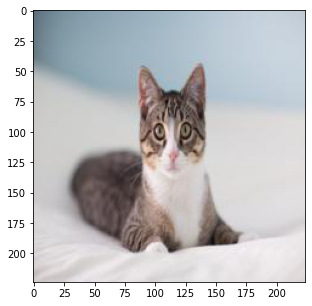

<IPython.core.display.Javascript object>

frac:  0.15
53
176
142
Sailiency maps
model pred: 0.68


,,
,,
,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

conv2_block1_preact_relu


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

index: 10
avg:0.12, pred0.34
result of outputs


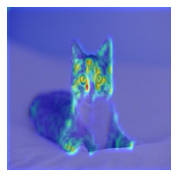

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

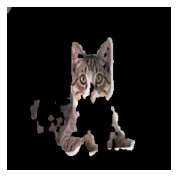

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

conv5_block1_preact_relu


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

index: 130
avg:0.12, pred0.70
result of outputs


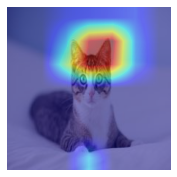

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

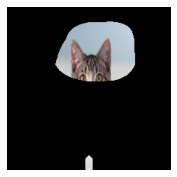

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

post_relu


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

index: 59
avg:0.03, pred0.72
result of outputs


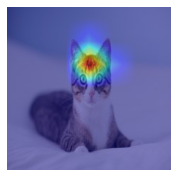

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

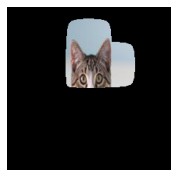

<IPython.core.display.Javascript object>

3.5320022106170654


In [178]:
masks = ['outputs'] # 'outputs', 'grads', 'outgrads' 중 보고 싶은 것들의 List
start = time()
main(img_name='cat1.jpg', 
     model=model,
     mask_layers = mask_layers[:1] + mask_layers[-2:], 
     mask_names=masks, 
     frac=0.15,
     positive_selection = False,
     nms_selection = True,  
     show_sp=False, 
     show_sm=True, 
     show_table=False)

print (time()-start)